## Tasks

### 1. Preliminary analysis

| Task    | Assigned to | Status |
|:----------------|:------------|:------:|
| What type of documents does it contain?  | Alberto | ✅ |
|       How many documents are there?       | Alberto | ✅ |
|       Calculate and visualise some simple statistics for the collection, e.g. the average document length, the average vocabulary size, etc.       | Tutti | ✅ |
|    BIO tagging for each file.       | Paolo | ✅ |
| Create datasets with sentences from the tagged dataset. | Paolo | ✅ |
| Create merged datasets | Paolo | ✅ |
| Cluster the documents and visualise the clusters to see what types of groups are present | Paolo | ✅ |
| Index the documents so that you can perform keyword search over them | Leonardo | ❌ |
| Train a Word2Vec embedding on the data and investigate the properties of the resulting embedding | Alberto | ✅ |


> **_KEY:_** [✅]() Completed [❌]() Not Completed

### 2. Training models

| Task    | Assigned to | Status |
|:----------------|:------------|:------:|
| Train a model to perform that task (by fine-tuning models on the training data)  | ??? | ❌ |
| Test pre-trained models on the task (if they already exist)                      | ??? | ❌ |
| Evaluate different models and compare their performance                          | ??? | ❌ |
> **_KEY:_** [✅]() Completed [❌]() Not Completed

> **_HINT_**: as a minimum here we would expect to see a linear classifier trained on the data (if an
appropriate for the task) and compare it with deep learning model, such as BERT.

### 3. Possible extensions:
Depending on the dataset chosen there will be many additional investigations you can perform.
For instance, oftentimes we can improve performance of a model on a particular task by simply
including additional data that is related to the task in its training set. So see if you can find other
data that helps with the task that you chose. Moreover, there are many NLP challenges out
there, so if you can’t find more data for the task you’re working on, look for another interesting
challenge to work on.

# KIND - Kessler Italian Named-entities Dataset

`KIND (Kessler Italian Named-entities Dataset)` is an Italian dataset for Named-Entity Recognition (NER).

The purpose of NER task is to tag all the named entity, namely identify all the objects in the real world.

In this case there are three categories to annotate:
- person (PER): a single individual, an animal or a group of humans with a proper name;
- organization (ORG): every formally established association defined by an organizational structure;
- location (LOC): geographical entities defined by political and/or social groups which possess a physical location and a proper name.

The dataset is composed by four different collections with texts taken from: 
- Wikinews (WN) as a source of news texts, picking articles belonging to the last two decades; 
- Italian fiction books (FIC) in the public domain ; 
- writings and speeches from Italian politician Aldo Moro (AM);
- public documents written by Alcide De Gasperi (ADG).

The texts belong to three different domains: news, literature, and political discourses.

The dataset contains more than one million tokens, of which around 600K are manually annotated instead the remaining part is semi-automatically annotated.


| Dataset   | Documents |
| --------- | --------- |
| Wikinews  | 1,000 |
| Fiction | 86 |
| Aldo Moro | 250 |
|Alcide De Gasperi | 158 |

From the given files is not possible to distinguish the different documents but only the sentences.

---

| The Overfitters    | PoliMi ID |
|:-------------------|:---------:|
|Pertino Paolo       | 10729600  |
|Pesce Leonardo      | 10659489  |
|Sandri Alberto      | 10698469  |

<br>

> **__Professor__** Mark James `transformer - robot + man`

> **__Teaching Assistant__** Vincenzo `Scotti`

## Table of Contents
* [0. Libraries](#libraries)
* [1. Data Import](#data-import)
    * [1.1 Merged Dataset generation](#merged-dataset-generation)
    * [1.2 Complete sentences generation](#complete-sentences-generation)
    * [1.3 BIO-tagging conversion](#bio-tagging-conversion)
* [2. Data Inspection](#data-inspection)
    * [2.1 Single dataset analysis](#single-dataset-analysis)
    * [2.2 Multiple dataset analysis](#multiple-dataset-analysis)
* [3. Vocabulary](#vocabulary)
    * [3.1 Single dataset vocabuary](#single-dataset-vocabulary)
    * [3.2 Multiple dataset vocabulary analysis](#multiple-datasets-vocabulary)
* [4. Clustering](#clustering)
    * [4.1 Documents vectorization](#documents-vectorization)
    * [4.2 KMeans algorithm](#kmeans-algorithm)
        * [4.2.1. Clusters visualization](#clusters-visualization)
        * [4.2.2. Topic modeling - c-TF-IDF](#topic-modeling---c-tf-idf)
        * [4.2.3. Topic modeling - LDA](#topic-modeling---lda)
        * [4.2.4. KMeans clustering final considerations](#kmeans-clustering-final-considerations)
* [5. Word embeddings](#word-embeddings)
    * [5.1 Word2Vec](#word2vec)
    * [5.2 fastText](#fasttext)
* [6. Indexing](#indexing)

## Libraries

In [2]:
import csv
import os
import random
import re
import string
import sys
from collections import Counter

import fasttext
import it_core_news_sm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd  # USE PANDAS 1.5.1
import plotly.express as px
import plotly.graph_objects as go
import pyterrier as pt
import spacy
from gensim.models.word2vec import Word2Vec
from IPython.display import display
from nltk.corpus import stopwords
from pandas.core.common import flatten
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, adjusted_mutual_info_score,
                             adjusted_rand_score, completeness_score, f1_score,
                             homogeneity_score, precision_score, recall_score,
                             v_measure_score)
from tqdm import tqdm
from umap import \
    UMAP  # if error on this import, downgrade numpy to 1.23.5 by using: pip install --upgrade numpy==1.23.5
from wordcloud import WordCloud
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

random.seed(0) # for reproducibility

# Italian stopwords
italian_stopwords_extended = ['a','abbastanza','abbia','abbiamo','abbiano','abbiate','accidenti','ad','adesso','affinché','agl','agli','ahime','ahimè','ai','al','alcuna','alcuni','alcuno','all','alla','alle','allo','allora','altre','altri','altrimenti','altro','altrove','altrui','anche','ancora','anni','anno','ansa','anticipo','assai','attesa','attraverso','avanti','avemmo','avendo','avente','aver','avere','averlo','avesse','avessero','avessi','avessimo','aveste','avesti','avete','aveva','avevamo','avevano','avevate','avevi','avevo','avrai','avranno','avrebbe','avrebbero','avrei','avremmo','avremo','avreste','avresti','avrete','avrà','avrò','avuta','avute','avuti','avuto','basta','ben','bene','benissimo','brava','bravo','buono','c','caso','cento','certa','certe','certi','certo','che','chi','chicchessia','chiunque','ci','ciascuna','ciascuno','cima','cinque','cio','cioe','cioè','circa','citta','città','ciò','co','codesta','codesti','codesto','cogli','coi','col','colei','coll','coloro','colui','come','cominci','comprare','comunque','con','concernente','conclusione','consecutivi','consecutivo','consiglio','contro','cortesia','cos','cosa','cosi','così','cui','d','da','dagl','dagli','dai','dal','dall','dalla','dalle','dallo','dappertutto','davanti','degl','degli','dei','del','dell','della','delle','dello','dentro','detto','deve','devo','di','dice','dietro','dire','dirimpetto','diventa','diventare','diventato','dopo','doppio','dov','dove','dovra','dovrà','dovunque','due','dunque','durante','e','ebbe','ebbero','ebbi','ecc','ecco','ed','effettivamente','egli','ella','entrambi','eppure','era','erano','eravamo','eravate','eri','ero','esempio','esse','essendo','esser','essere','essi','ex','fa','faccia','facciamo','facciano','facciate','faccio','facemmo','facendo','facesse','facessero','facessi','facessimo','faceste','facesti','faceva','facevamo','facevano','facevate','facevi','facevo','fai','fanno','farai','faranno','fare','farebbe','farebbero','farei','faremmo','faremo','fareste','faresti','farete','farà','farò','fatto','favore','fece','fecero','feci','fin','finalmente','finche','fine','fino','forse','forza','fosse','fossero','fossi','fossimo','foste','fosti','fra','frattempo','fu','fui','fummo','fuori','furono','futuro','generale','gente','gia','giacche','giorni','giorno','giu','già','gli','gliela','gliele','glieli','glielo','gliene','grande','grazie','gruppo','ha','haha','hai','hanno','ho','i','ie','ieri','il','improvviso','in','inc','indietro','infatti','inoltre','insieme','intanto','intorno','invece','io','l','la','lasciato','lato','le','lei','li','lo','lontano','loro','lui','lungo','luogo','là','ma','macche','magari','maggior','mai','male','malgrado','malissimo','me','medesimo','mediante','meglio','meno','mentre','mesi','mezzo','mi','mia','mie','miei','mila','miliardi','milioni','minimi','mio','modo','molta','molti','moltissimo','molto','momento','mondo','ne','negl','negli','nei','nel','nell','nella','nelle','nello','nemmeno','neppure','nessun','nessuna','nessuno','niente','no','noi','nome','non','nondimeno','nonostante','nonsia','nostra','nostre','nostri','nostro','novanta','nove','nulla','nuovi','nuovo','o','od','oggi','ogni','ognuna','ognuno','oltre','oppure','ora','ore','osi','ossia','ottanta','otto','paese','parecchi','parecchie','parecchio','parte','partendo','peccato','peggio','per','perche','perchè','perché','percio','perciò','perfino','pero','persino','persone','però','piedi','pieno','piglia','piu','piuttosto','più','po','pochissimo','poco','poi','poiche','possa','possedere','posteriore','posto','potrebbe','preferibilmente','presa','press','prima','primo','principalmente','probabilmente','promesso','proprio','puo','pure','purtroppo','può','qua','qualche','qualcosa','qualcuna','qualcuno','quale','quali','qualunque','quando','quanta','quante','quanti','quanto','quantunque','quarto','quasi','quattro','quel','quella','quelle','quelli','quello','quest','questa','queste','questi','questo','qui','quindi','quinto','realmente','recente','recentemente','registrazione','relativo','riecco','rispetto','salvo','sara','sarai','saranno','sarebbe','sarebbero','sarei','saremmo','saremo','sareste','saresti','sarete','sarà','sarò','scola','scopo','scorso','se','secondo','seguente','seguito','sei','sembra','sembrare','sembrato','sembrava','sembri','sempre','senza','sette','si','sia','siamo','siano','siate','siete','sig','solito','solo','soltanto','sono','sopra','soprattutto','sotto','spesso','sta','stai','stando','stanno','starai','staranno','starebbe','starebbero','starei','staremmo','staremo','stareste','staresti','starete','starà','starò','stata','state','stati','stato','stava','stavamo','stavano','stavate','stavi','stavo','stemmo','stessa','stesse','stessero','stessi','stessimo','stesso','steste','stesti','stette','stettero','stetti','stia','stiamo','stiano','stiate','sto','su','sua','subito','successivamente','successivo','sue','sugl','sugli','sui','sul','sull','sulla','sulle','sullo','suo','suoi','tale','tali','talvolta','tanto','te','tempo','terzo','th','ti','titolo','tra','tranne','tre','trenta','triplo','troppo','trovato','tu','tua','tue','tuo','tuoi','tutta','tuttavia','tutte','tutti','tutto','uguali','ulteriore','ultimo','un','una','uno','uomo','va','vai','vale','vari','varia','varie','vario','verso','vi','vicino','visto','vita','voi','volta','volte','vostra','vostre','vostri','vostro','è','ch', 'disse']

/home/leonardo/KIND_Pertino_Pesce_Sandri/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/MyDrive/Colab Notebooks/NLP/KIND-main')
    os.getcwd()

    print("Colab environment detected. Paths have been set.")
else:
    print("You are not running in Google Colab. Skipping this step...")

You are not running in Google Colab. Skipping this step...


In [4]:
!{sys.executable} -m spacy download it_core_news_sm;
!pip install --upgrade numpy==1.23.5;
!pip install umap-learn;
!pip install fasttext;
!pip install wordcloud;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/leonardo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Import

In the following section we manipulate the dataset provided to get the full sentences that have been annotated by the original authors.

First we create the directories if they do not exist.

In [16]:
os.mkdir(os.path.join(os.getcwd(), 'dataset')) if not os.path.exists(os.path.join(os.getcwd(), 'dataset')) else None
os.mkdir(os.path.join(os.getcwd(), 'dataset/txt-version')) if not os.path.exists(os.path.join(os.getcwd(), 'dataset/txt-version')) else None
os.mkdir(os.path.join(os.getcwd(), 'dataset/BIO-tagged-version')) if not os.path.exists(os.path.join(os.getcwd(), 'dataset/BIO-tagged-version')) else None

### Merged dataset generation

We want to provide an additional dataset in which content of all the files is merged together. This will be useful for the subsequent tasks.

First we merge the initial `.tsv` train files:

In [17]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset')
dataset_files = os.listdir(dataset_dir)

# Merging all train.tsv files together
content = ""
for file in tqdm(dataset_files):
    # We are dealing with the train.tsv files only
    if file.endswith('test.tsv') or not file.endswith('.tsv'):
        continue

    file_path = os.path.join(dataset_dir, file)  

    # Read the content of the file and appending it to the content variable
    with open(file_path, 'r') as f:
        content += f.read()
    
# Write the merged content back to the file if it doesn't exist already
if not os.path.exists(f'{dataset_dir}/merged_dataset_train.tsv'):
    with open(f'{dataset_dir}/merged_dataset_train.tsv', 'w') as f:
        f.write(content)

100%|██████████| 12/12 [00:00<00:00, 356.78it/s]


Now we do the same for the test files:

In [18]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset')
dataset_files = os.listdir(dataset_dir)

# Merging all test.tsv files together
content = ""
for file in tqdm(dataset_files):
    # We are dealing with the test.tsv files only
    if file.endswith('train.tsv') or not file.endswith('.tsv'):
        continue

    file_path = os.path.join(dataset_dir, file)  

    # Read the content of the file and appending it to the content variable
    with open(file_path, 'r') as f:
        content += f.read()
    
# Write the merged content back to the file if it doesn't exist already
if not os.path.exists(f'{dataset_dir}/merged_dataset_test.tsv'):
    with open(f'{dataset_dir}/merged_dataset_test.tsv', 'w') as f:
        f.write(content)

100%|██████████| 13/13 [00:00<00:00, 2404.35it/s]


### Complete sentences generation

Now for each train and test `.tsv` file we want to retrieve the compact form of the sentences that have been annotated by the original authors.

For each file, sentences have been reconstructed and allocated one-for-row in the corresponding `.txt` file.

In [19]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset')
dataset_files = os.listdir(dataset_dir)

# For each file in the dataset directory split the content when finding empty lines
for file in tqdm(dataset_files):
    # Do not read txt files
    if not file.endswith('.tsv'):
        continue

    # Get the .tsv file path
    file_path = os.path.join(dataset_dir, file)

    # Inserting the content of the tsv file into a dataframe keeping the blank lines (i.e. the end of a sentence)
    data_df = pd.read_csv(file_path, sep='\t', names=['Word', 'Entity'], skip_blank_lines=False, quoting=csv.QUOTE_NONE)

    # Replace NaN values with a new line (\n) to mark the beginning of a new phrase
    data_df.fillna('\n', inplace=True)
    
    # Reconsetructing the sentences by joining the words together
    sentences = " ".join(data_df['Word']).replace('\n ', '\n') #.replace(' .', '.').replace(' ,', ',').replace(' !', '!').replace(' ?', '?').replace(' :', ':').replace(' ;', ';').replace(' %', '%').replace(' )', ')').replace('( ', '(').replace(' ]', ']').replace('[ ', '[').replace(' }', '}').replace('{ ', '{')
    
    # Write the content back to a text file if it doesn't exist already
    output_file_path = f"{os.path.join(os.getcwd(), 'dataset/txt-version')}/{file[:-3] + 'txt'}"
    if not os.path.exists(output_file_path):
        with open(output_file_path , 'w') as f:
            f.write(sentences)

100%|██████████| 14/14 [00:01<00:00, 10.76it/s]


### Bio tagging conversion

Finally, we convert into BIO-tagging format the entities in the datasets.

In [20]:
o_tag = "O"
types = set()
count = {}

# Dictionary of input and output files names
files = {
	"wikinews_train.tsv": "WN_train.tsv",
	"wikinews_test.tsv": "WN_test.tsv",
	"fiction_train.tsv": "FIC_train.tsv",
	"fiction_test.tsv": "FIC_test.tsv",
	"degasperi_train.tsv": "ADG_train.tsv",
	"degasperi_test.tsv": "ADG_test.tsv",
	"moro_train.tsv": "AM_train.tsv",
	"moro_test.tsv": "AM_test.tsv",
	"merged_dataset_train.tsv": "MERGED_train.tsv",
	"merged_dataset_test.tsv": "MERGED_test.tsv",
}

for file in tqdm(files):
	with open(f"{os.path.join(os.getcwd(), 'dataset')}/{file}", "r") as f:
		# Getting the output file name related to the current file
		out_file = files[file]
		count[out_file] = {"sentences": 0, "tags": {}, "tokens": 0}

		sentences = []
		current_sentence = []

		for line in f:
			line = line.strip()
			if len(line) == 0:
				if len(current_sentence) > 0:
					sentences.append(current_sentence)
					current_sentence = []
				continue
			parts = line.split("\t")
			current_sentence.append(parts)
			count[out_file]["tokens"] += 1

		if len(current_sentence) > 0:
			sentences.append(current_sentence)

		count[out_file]["sentences"] = len(sentences)

		# BIO tagging conversion. The first non-O tag after a sequence of O-tags is converted to B-tag.
		# The following non-O tags (the ones that follow the B-tag) are converted to I-tags until
		# an O-tag is found. The same procedure is repeated for each sequence of non-O tags
		for sentence in sentences:
			previous_ner = o_tag
			for token in sentence:
				ner = token[1]
				new_ner = ner
				if ner != o_tag:
					if previous_ner != ner:
						if ner not in count[out_file]["tags"]:
							count[out_file]["tags"][ner] = 0
						new_ner = "B-" + ner
						count[out_file]["tags"][ner] += 1
						types.add(ner)
					else:
						new_ner = "I-" + ner
				token[1] = new_ner
				previous_ner = ner

		# Writing the converted file into the appropriate directory if it doesn't exist already
		if not os.path.exists(f"{os.path.join(os.getcwd(), 'dataset/BIO-tagged-version')}/{out_file}"):
			with open(f"{os.path.join(os.getcwd(), 'dataset/BIO-tagged-version')}/{out_file}", "w") as fw:
				for sentence in sentences:
					for token in sentence:
						fw.write(token[0])
						fw.write("\t")
						fw.write(token[1])
						fw.write("\n")
					fw.write("\n")

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


## Data inspection

### Single dataset analysis

Let's analyze a single dataset, we take `degasperi_train.tsv`

In [11]:
# Path of file degasperi_train.tsv
file_path = os.path.join(os.getcwd(), 'dataset/degasperi_train.tsv')

# Each row of the dataframe is a word with associated type of entity
data_df = pd.read_csv(file_path, sep='\t', names=['Word', 'Entity'])

In [12]:
# See first elements
data_df.head()

Word Entity
0        Il      O
1  ministro      O
2     degli      O
3    Esteri      O
4        al      O

In [13]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123504 entries, 0 to 123503
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Word    123504 non-null  object
 1   Entity  123504 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


All elements are not null.

In [14]:
data_df.describe()

Word  Entity
count   123504  123504
unique   15449       4
top          ,       O
freq      6200  118933

In [15]:
data_df[:25]

Word Entity
0            Il      O
1      ministro      O
2         degli      O
3        Esteri      O
4            al      O
5   commissario      O
6          capo      O
7         della      O
8   Commissione    ORG
9       alleata    ORG
10         Sono      O
11    informato      O
12          che      O
13           l'      O
14       ordine      O
15           n.      O
16           14      O
17            ,      O
18       emesso      O
19           il      O
20           10      O
21    settembre      O
22          dal      O
23      Governo    ORG
24     Militare    ORG

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

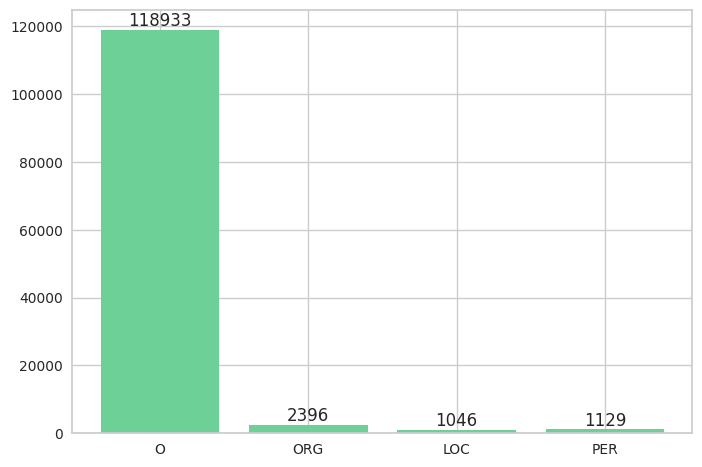

In [16]:
counts_entity = Counter(data_df['Entity'])

plt.bar(counts_entity.keys(), counts_entity.values(), color="#6dd197", width=0.8)

# Add the values to the plot
for i, value in enumerate(counts_entity.values()):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

There is a huge unbalance between the 'O' class and the other classes.

There are three classes: person (PER), location (LOC) and organization(ORG).

The tag 'O' is used when a word is not a named entity.

In [17]:
# Retrieve all words with label 'PER'
persons = data_df.loc[data_df['Entity'] == 'PER', 'Word']
persons_set = set(persons)
print(f'There are {len(persons_set)} different words labelled as PER')
sorted(persons_set)[:10]

There are 412 different words labelled as PER


['A.',
 'Achille',
 'Adami',
 'Adenauer',
 'Adler',
 'Aehrenthal',
 'Agnesi',
 'Agostino',
 'Alcide',
 'Alessio']

In [18]:
# Retrieve all words with label 'LOC'
locations = data_df.loc[data_df['Entity'] == 'LOC', 'Word']
locations_set = set(locations)
print(f'There are {len(locations_set)} different words labelled as LOC')
sorted(locations_set)[:10]

There are 304 different words labelled as LOC


['10',
 'Adige',
 'Adria',
 'Adriatico',
 'Africa',
 'Aia',
 'Aja',
 'Ala',
 'Aldeno',
 'Aldobrandini']

In [19]:
# Retrieve all words with label 'ORG'
organizations = data_df.loc[data_df['Entity'] == 'ORG', 'Word']
organizations_set = set(organizations)
print(f'There are {len(organizations_set)} different words labelled as ORG')
sorted(organizations_set)[:10]

There are 521 different words labelled as ORG


['(uniti)',
 '5ª',
 'Adige',
 'Agricoltura',
 'Aja',
 'Alleate',
 'Alleati',
 'Alleato',
 'Alpine',
 'Alto']

### Multiple dataset analysis

In this section we retrieve some statistics for all the four training dataset plus the merged one.

In [20]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset')
dataset_files = os.listdir(dataset_dir)
datasets = dict()

# Create a dictionary with all train datasets
for file in tqdm(dataset_files):
    # We are dealing with the train.tsv files only
    if file.endswith('test.tsv') or not file.endswith('.tsv'):
        continue

    file_path = os.path.join(dataset_dir, file)  

    # Inserting the content of the tsv file into a dataframe and add it to the dictionary
    datasets[str(file)[:-4]] = pd.read_csv(file_path, sep='\t', names=['Word', 'Entity'])

100%|██████████| 14/14 [00:01<00:00,  7.88it/s]


In [21]:
for dataset in datasets.keys():
  print(f'\nDataset {dataset}')
  datasets[dataset].info()


Dataset degasperi_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123504 entries, 0 to 123503
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Word    123504 non-null  object
 1   Entity  123504 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB

Dataset merged_dataset_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033732 entries, 0 to 3033731
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Word    object
 1   Entity  object
dtypes: object(2)
memory usage: 46.3+ MB

Dataset moro_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309796 entries, 0 to 309795
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Word    309796 non-null  object
 1   Entity  309796 non-null  object
dtypes: object(2)
memory usage: 4.7+ MB

Dataset wikinews_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154193 entries, 0 to 1

In [22]:
for dataset in datasets.keys():
  print(f'\nDataset {dataset}')
  display(datasets[dataset].describe())


Dataset degasperi_train


Word  Entity
count   123504  123504
unique   15449       4
top          ,       O
freq      6200  118933


Dataset merged_dataset_train


Word   Entity
count   3033732  3033732
unique    48133        4
top           ,        O
freq     176364  2905296


Dataset moro_train


Word  Entity
count   309796  309796
unique   17315       4
top          ,       O
freq     20053  301471


Dataset wikinews_train


Word  Entity
count   154193  154193
unique   22029       4
top          ,       O
freq      8854  139334


Dataset fiction_train


Word  Entity
count   170940  170940
unique   19169       4
top          ,       O
freq      8984  166586

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

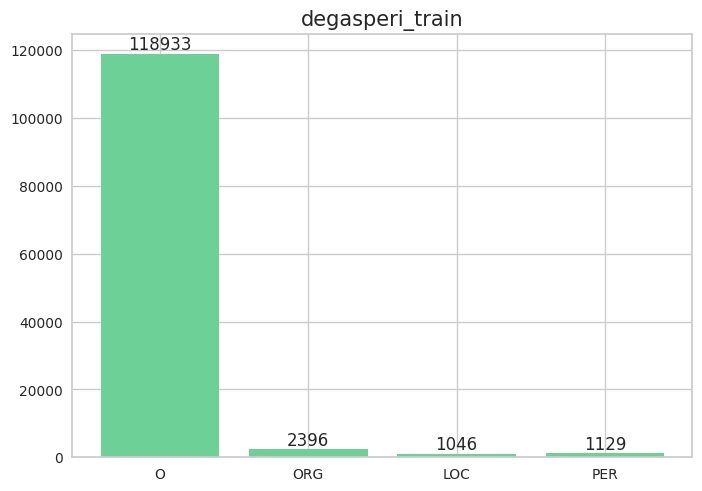

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

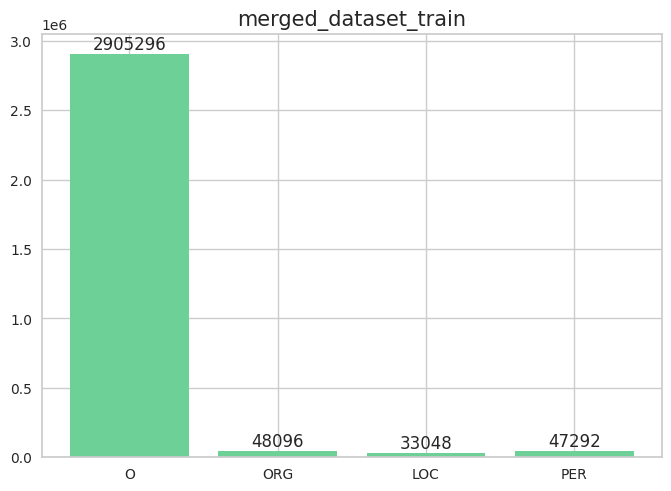

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

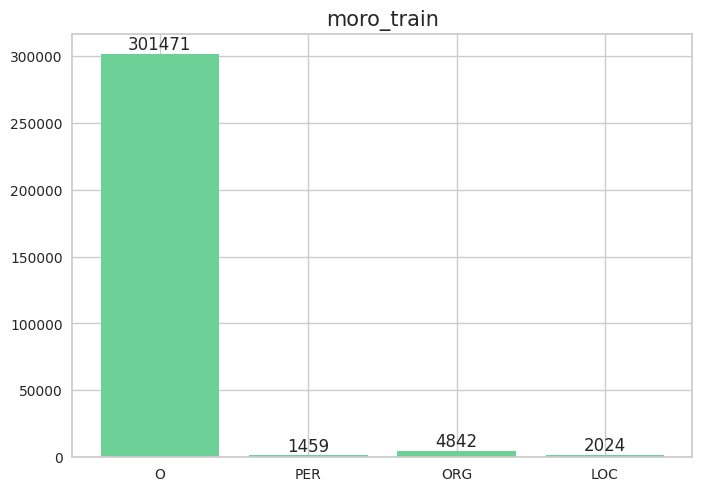

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

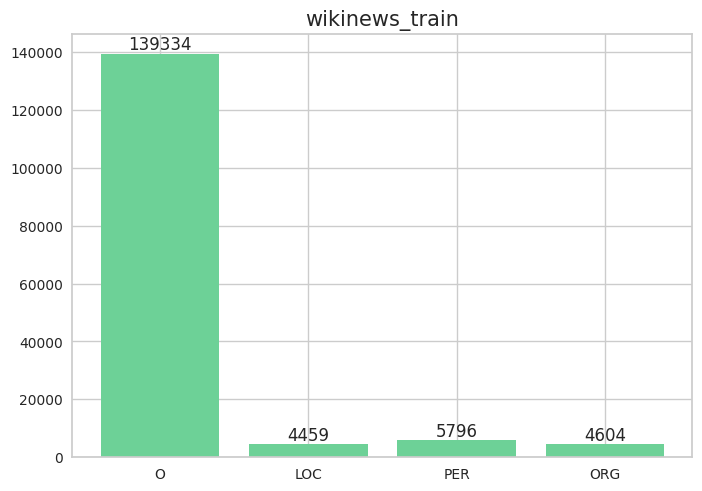

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

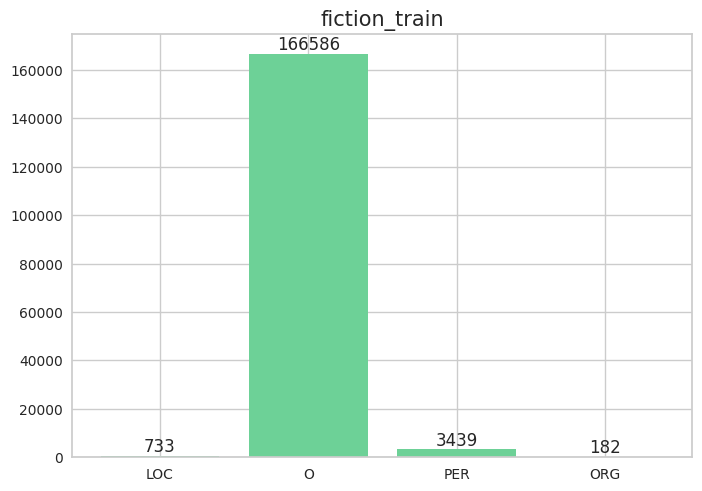

In [23]:
for dataset in datasets.keys():
  counts_entity = Counter(datasets[dataset]['Entity'])

  plt.bar(counts_entity.keys(), counts_entity.values(), color="#6dd197", width=0.8)

  # Add the values to the plot
  for i, value in enumerate(counts_entity.values()):
      plt.text(i, value, str(value), ha='center', va='bottom')
  plt.title(dataset, fontsize=15)      

  plt.show()

In [24]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset/txt-version')
dataset_files = os.listdir(dataset_dir)
datasets = dict()

# Create a dictionary with all train datasets
for file in tqdm(dataset_files):
    # We are dealing with the train.txt files only
    if file.endswith('test.txt') or not file.endswith('.txt'):
        continue

    file_path = os.path.join(dataset_dir, file)  

    # Add each txt file to the dictionary
    with open(file_path, 'r') as f:
      datasets[str(file)[:-4]] = f.read()

100%|██████████| 10/10 [00:00<00:00, 84.96it/s]


In [25]:
for dataset in datasets.keys():
  print(f'The length of the text of {dataset} is {len(datasets[dataset])} characters')

The length of the text of fiction_train is 909398 characters
The length of the text of merged_dataset_train is 19606140 characters
The length of the text of degasperi_train is 723072 characters
The length of the text of moro_train is 1843647 characters
The length of the text of wikinews_train is 1425418 characters


In [26]:
for dataset in datasets.keys():
  # Obtain all the sentences
  sentences = re.split('\n', datasets[dataset])
  # Obtain all words
  words = re.sub('\W', ' ', datasets[dataset]).split()
  print(f'The dataset {dataset} has {len(sentences)} sentences and {len(words)} words') 

The dataset fiction_train has 11424 sentences and 147333 words
The dataset merged_dataset_train has 151061 sentences and 3025808 words
The dataset degasperi_train has 5148 sentences and 110692 words
The dataset moro_train has 10284 sentences and 277161 words
The dataset wikinews_train has 10913 sentences and 221266 words


Between the four datasets we have an even distribution of sentences between `Wikinews`, `Moro` and `Fiction` but we have more or less half the sentences in `De Gasperi`. This may be relevant for future analysis.

Visualize the most common words, once the stopwords are removed since they are very frequent in the texts.

In [27]:
def remove_stopwords(text):
  'Given a text it removes all the italian stopwords\
   and returns a list with the remaining words.'

  # List of stopwords to remove
  words_to_remove = italian_stopwords_extended

  # Regex to match the stopwords
  pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', flags=re.IGNORECASE)

  # Replace the stopwords with an empty string
  clean_text = pattern.sub('', text)

  # Tokenize text
  words_list = re.sub('[^a-zA-Z_]', ' ', clean_text).split() 

  words_list = [word for word in words_list if len(word) > 1]

  return words_list

In [28]:
counters = list()

# Count most common words in each dataset
for dataset in datasets.keys():
  counts_word = Counter(remove_stopwords(datasets[dataset]))
  counters.append(counts_word)
  print(f'\nDataset {dataset} {counts_word.most_common(10)}')


Dataset fiction_train [('casa', 259), ('Ada', 216), ('Giorgio', 183), ('occhi', 162), ('Miriam', 153), ('signora', 150), ('essa', 150), ('padre', 148), ('altra', 129), ('Severa', 127)]

Dataset merged_dataset_train [('politica', 5436), ('Italia', 4112), ('Governo', 3592), ('partito', 3036), ('governo', 2980), ('situazione', 2312), ('politico', 2268), ('libert', 2224), ('Democrazia', 2220), ('forze', 2044)]

Dataset degasperi_train [('governo', 257), ('partito', 178), ('Italia', 178), ('politica', 171), ('libert', 138), ('popolo', 135), ('guerra', 123), ('Camera', 112), ('nazionale', 103), ('Governo', 102)]

Dataset moro_train [('politica', 1092), ('Governo', 743), ('Democrazia', 537), ('Italia', 519), ('Cristiana', 470), ('partito', 459), ('Moro', 446), ('politico', 438), ('Partito', 391), ('situazione', 387)]

Dataset wikinews_train [('presidente', 315), ('Italia', 315), ('causa', 176), ('Roma', 171), ('governo', 170), ('morte', 157), ('polizia', 144), ('dichiarato', 142), ('vittime'

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

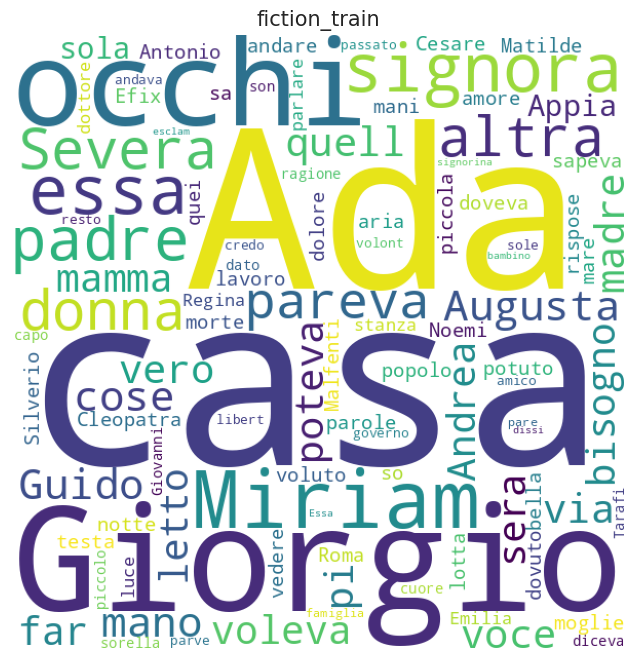

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

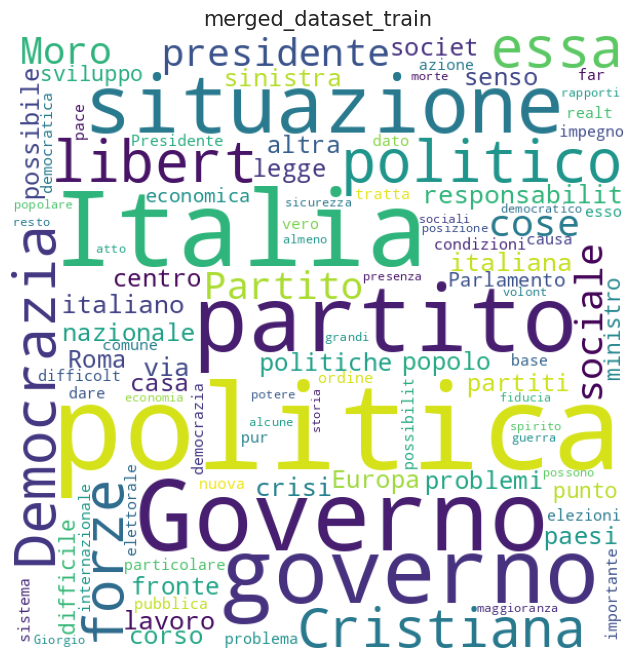

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

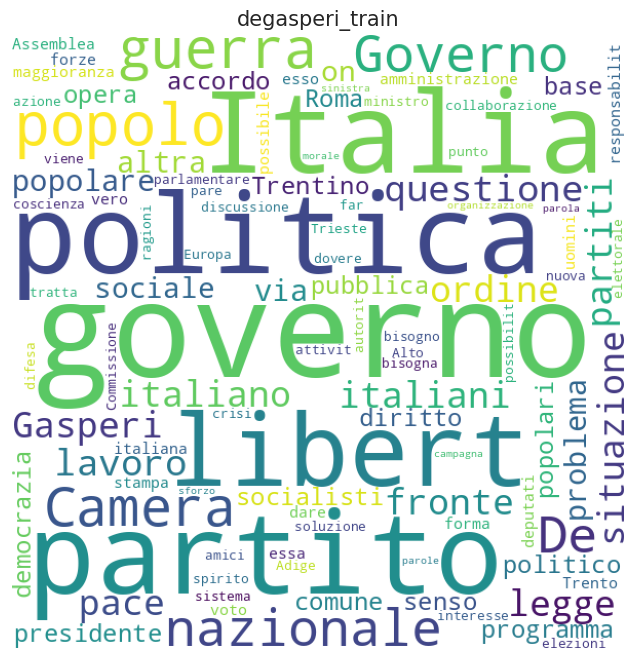

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

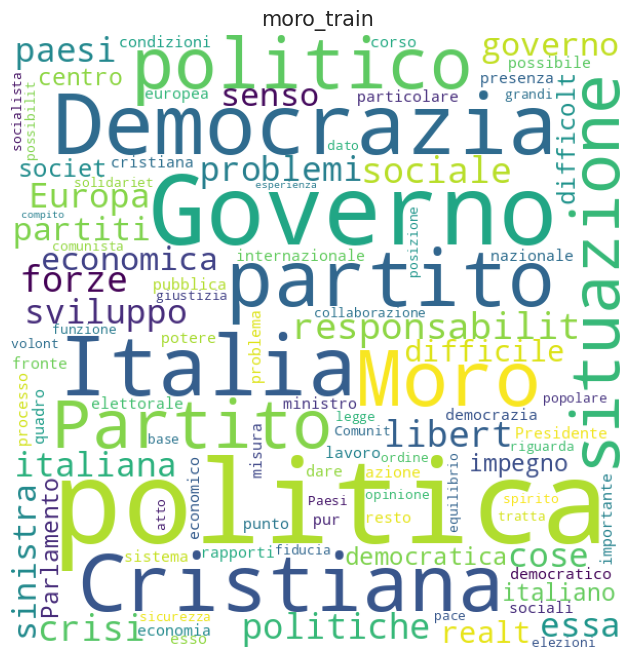

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

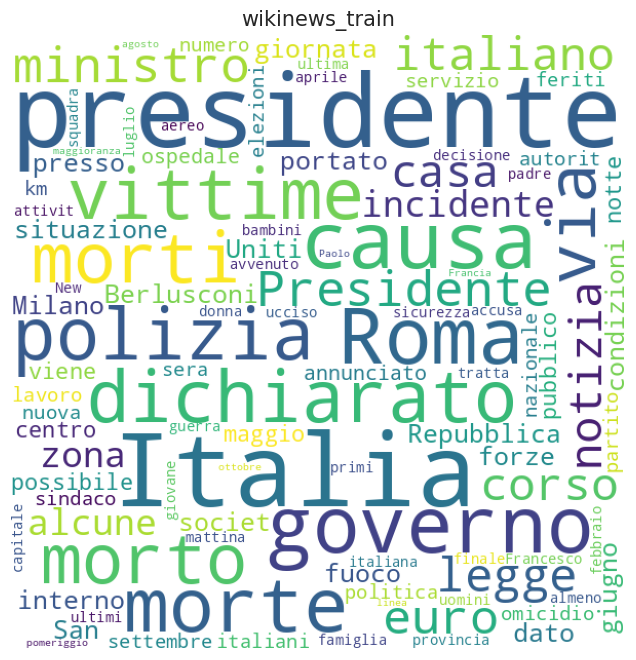

In [29]:
for i,dataset in enumerate(datasets.keys()):
  # Generate the word cloud
  wordcloud = WordCloud(height=600, width=600,
                        background_color='white',
                        min_font_size=10, max_words=100,
                        colormap='viridis').generate_from_frequencies(counters[i])

  plt.figure(figsize=(8, 8), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(dataset, fontsize=15) 
  plt.show()

## Vocabulary

In this chapter we analyze briefly the vocabulary of our datasets.


### Single dataset vocabulary

Vocabulary for a single dataset, we take `degasperi_train.txt` as running example.

In [30]:
# Open the text file degasperi_train.txt
file_path = os.path.join(os.getcwd(), 'dataset/txt-version/degasperi_train.txt')

with open(file_path, 'r') as f:
    text = f.read()

print(text[:150])

Il ministro degli Esteri al commissario capo della Commissione alleata 
Sono informato che l' ordine n. 14 , emesso il 10 settembre dal Governo Milita


In [31]:
regex = '[' + string.punctuation + ']'

# Remove all the punctuation (maybe not necessary)
text_no_punctuation = re.sub(regex,'',text)

print(text_no_punctuation[:150])

Il ministro degli Esteri al commissario capo della Commissione alleata 
Sono informato che l ordine n 14  emesso il 10 settembre dal Governo Militare 


In [32]:
# Obtain all the sentences
sentences = re.split('\n', text_no_punctuation)

In [33]:
print(f'The length of the text with punctuation is {len(text)} characters')
print(f'The length of the text without punctuation is {len(text_no_punctuation)} characters')
print(f'{len(text) - len(text_no_punctuation)} characters are removed')

The length of the text with punctuation is 723072 characters
The length of the text without punctuation is 707468 characters
15604 characters are removed


In [34]:
# Build vocabulary
# Convert to lowercase, split on whitespace, select only distinct words, sort the words alphabetically
words = text_no_punctuation.lower().split()
vocabulary = sorted(set(words))
print(f'The vocabulary contains {len(vocabulary)} words')
#print(vocabulary)

counts_word = Counter(words)
print(f'Most common words: {counts_word.most_common(10)}')

The vocabulary contains 14395 words
Most common words: [('di', 3684), ('e', 3235), ('che', 3080), ('la', 2432), ('il', 2314), ('non', 1409), ('in', 1406), ('è', 1379), ('l', 1337), ('per', 1296)]


In [35]:
# Build vocabulary using CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(sentences)

print(f'The vocabulary contains {len(vectorizer.get_feature_names_out())} words')
vectorizer.get_feature_names_out()[:150]

The vocabulary contains 14357 words


array(['10', '100', '10859554', '11', '12', '120', '127', '128', '13',
       '131', '14', '143', '1456', '15', '156', '16', '160', '1644231',
       '167', '17', '170', '1700', '18', '1814', '1848', '1879', '1881',
       '1882', '1890', '1892', '19', '1900', '1903', '1908', '1909',
       '1910', '1911', '1912', '1913', '1914', '1918', '1919', '1920',
       '192021', '1921', '1922', '1923', '1924', '1939', '1943', '1944',
       '1945', '1946', '194654', '1947', '194748', '1948', '1949',
       '195051', '1951', '1952', '1953', '1992', '20', '200', '20000',
       '2021', '207', '21', '210', '22', '221', '2295', '23', '230',
       '2315', '2345', '238', '24', '25', '26', '27', '2730', '28', '29',
       '30', '300', '31', '33', '344', '346486', '347', '35', '36', '362',
       '363', '38', '380', '381', '395', '40', '400', '407', '41', '45',
       '4600', '48', '49', '50', '51', '52', '53', '55', '557', '5657',
       '58', '580', '591', '5ª', '60', '61', '6122638', '62', '625', '

In [36]:
#print('Italian stopwords:')
#print(stopwords.words('italian'))

In [37]:
# Build vocabulary by removing italian stop words and with words with at least 3 occurences
vectorizer = CountVectorizer(min_df=3, stop_words=stopwords.words('italian'))
vectorizer.fit(sentences)
print(f"vocabulary size: {len(vectorizer.get_feature_names_out())}")
# vectorizer.get_feature_names_out()[:50]

vocabulary size: 4090


### Multiple datasets vocabulary


Let's build the vocabulary for each training set

In [38]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset/txt-version')
dataset_files = os.listdir(dataset_dir)
datasets = dict()

# Create a dictionary with all train datasets
for file in tqdm(dataset_files):
    # We are dealing with the train.txt files only
    if file.endswith('test.txt') or not file.endswith('.txt'):
        continue

    file_path = os.path.join(dataset_dir, file)  

    # Add each txt file to the dictionary
    with open(file_path, 'r') as f:
      datasets[str(file)[:-4]] = f.read()

100%|██████████| 10/10 [00:00<00:00, 95.26it/s]


In [39]:
# Dictionary that contains the vocabulary of each dataset
vocabularies = dict()

regex = '[' + string.punctuation + ']'

for dataset in datasets.keys():
  # Get the text
  text = datasets[dataset]

  # Remove all the punctuation (maybe not necessary)
  text_no_punctuation = re.sub(regex,'',text)

  # Obtain all the sentences
  sentences = re.split('\n', text_no_punctuation)

  # Build vocabulary by removing italian stop words and with words with at least 3 occurences
  vectorizer = CountVectorizer(min_df=3, stop_words=stopwords.words('italian'))
  vectorizer.fit(sentences)

  # Save vocabulary
  vocabularies[dataset] = vectorizer
  print(f"{dataset} vocabulary size: {len(vectorizer.get_feature_names_out())}")

fiction_train vocabulary size: 5079
merged_dataset_train vocabulary size: 47430
degasperi_train vocabulary size: 4090
moro_train vocabulary size: 6705
wikinews_train vocabulary size: 8438


In [40]:
vocabularies['merged_dataset_train'].get_feature_names_out()[-50:]

array(['zoppica', 'zoppicai', 'zoppicando', 'zoppicava', 'zoppo', 'zoran',
       'zorreguieta', 'zorro', 'zotico', 'zotpa', 'zu', 'zuannantò',
       'zubirán', 'zuccalà', 'zuccari', 'zuccherati', 'zucchero',
       'zuccheroso', 'zucchette', 'zuccon', 'zuckerberg', 'zufolando',
       'zufolava', 'zuma', 'zuppa', 'zuppiera', 'zurigo', 'zurlì',
       'zurma', 'zuwarah', 'zuzanna', 'zygadlo', 'zyuganov', 'àmbito',
       'àngora', 'álvaro', 'économique', 'élite', 'équipe', 'évoqués',
       'êra', 'óscar', 'černivci', 'šachtar', 'šefčovič', 'željko',
       'žilina', 'žirinovskij', 'ʿuqba', 'ḥoseynī'], dtype=object)

## Clustering

In this section we perform clustering on the aggregated dataset in order to find out if there are any groups of documents that are similar to each other and if they are related to the original domain they belong to.

> **_REMARK:_** To do clustering tasks we should have enough long corpus. In our case we have sentences, so by nature not very long texts. We can try to cluster them, but the results may not be very good.

First of all we are going to read the merged dataset (both the training and the test one) and we collect them together.

In [21]:
content_train = []
content_test  = []

with open('dataset/txt-version/merged_dataset_train.txt', 'r') as f_train, open('dataset/txt-version/merged_dataset_test.txt', 'r') as f_test:
    for i, train_line in enumerate(f_train):
        content_train.append(train_line)
    
    for i, test_line in enumerate(f_test):
        content_test.append(test_line)

# Setting up the labels
train_labels = [0 for i in range(10283)] + [3 for i in range(10912)] + [1 for i in range(11423)] + [2 for i in range(5147)] # [MORO, WIKINEWS, FICTION, DEGASPERI]
test_labels = [1 for i in range(1051)] + [3 for i in range(2594)] + [0 for i in range(2618)] + [2 for i in range(1122)] # [FICTION, WIKINEWS, MORO, DEGASPERI]

indices_train = [i for i in range(len(content_train))]
indices_test = [i for i in range(len(content_test))]

random.shuffle(indices_train)
random.shuffle(indices_test)

random_content_train = [content_train[i] for i in indices_train]
random_content_test = [content_test[i] for i in indices_test]
random_train_labels = [train_labels[i] for i in indices_train]
random_test_labels = [test_labels[i] for i in indices_test]

content_train = random_content_train
content_test = random_content_test
train_labels = random_train_labels
test_labels = random_test_labels

# random.shuffle(content_train)
# random.shuffle(content_test)

In [ ]:
len(content_train)

As we can see the final dataset is composed by 37765 sentences which has to be clustered.

### Documents vectorization

In order to cluster the documents, we need to first convert them into a numerical vector format. To do so a `FastText` model is trained on our corpus and then used to embed the sentences of the dataset.

Two main types of models can be used:
* `Continuous Bag of Words` (CBOW) model
* `Skip-gram` model

The skipgram model learns to predict a target word thanks to a nearby word. On the other hand, the cbow model predicts the target word according to its context. The context is represented as a bag of the words contained in a fixed size window around the target word.

We decided to use the `CBOW` model because it is faster to train and it performs better on frequent words.

<img src="https://fasttext.cc/img/cbo_vs_skipgram.png">

In [ ]:
if os.path.exists('./ft_cbow_model.bin'):
    ft_cbow_model = fasttext.load_model('./ft_cbow_model.bin')
else:
    ft_cbow_model = fasttext.train_unsupervised('./dataset/txt-version/merged_dataset_train.txt', model='cbow')
vocabulary = ft_cbow_model.words

Finally let's vectorize all the sentences.

In [ ]:
vectorized_sentences_train = np.array([ft_cbow_model.get_sentence_vector(sentence.strip()) for sentence in content_train])
vectorized_sentences_test = np.array([ft_cbow_model.get_sentence_vector(sentence.strip()) for sentence in content_test])

### KMeans Algorithm

Now, we'll try to cluster the data. To do so the KMeans algorithm is being applied. Even though this algorithm is one of the most used to deal with clustering tasks, it has one main drawback: the number of clusters to use has to be chosen in advace. There are several methods which helps in defining such a number. We'll use the most used ones, i.e. `Elbow Method` and `Avarage Silhouette Method`.

In [ ]:
kmeans = KMeans(random_state=0)
elbow_visualizer = KElbowVisualizer(kmeans, k=(2,10))

elbow_visualizer.fit(vectorized_sentences_train)        # Fit the data to the visualizer
elbow_visualizer.show() 

The elbow method is not giving us a clear answer. It suggests a number of clusters equal to 4, but as we can see from the plot of the Elbow Curve there is not a clear elbow point.

Let's proceed by applying the Avarage Silhouette method. Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of $[-1, 1]$.

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In [ ]:
possible_cluster_numbers = range(3, 7)

# We have 10 possible cluster numbers, so 10 plots
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 6))
fig.tight_layout()

for i, cluster_number in enumerate(possible_cluster_numbers):
    model_current_cluster_number = KMeans(n_clusters = cluster_number, random_state=0)
    sil_visualizer = SilhouetteVisualizer(model_current_cluster_number, ax = axs[i])
    sil_visualizer.fit(vectorized_sentences_train)    
    axs[i].set_title(f'{cluster_number} clusters') 

The following conditions should be checked to pick the right ‘K’ using the Silhouette plots:
1. For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line). The x-axis represents the Silhouette score. For each case the avarage score is around 0.2, which in principle is quite a low value (as a rule of thumb, a value of 0.5 and above is considered a good score).
2. There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points and it should be similar for all the clusters. This property reduces our scope to a cluster number equal to 3 or 4 clusters.

Let's keep for the moment the number of clusters equal to 4 and let's see how the sentences are distributed among them.

In [ ]:
n_cluster = 4

kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(vectorized_sentences_train)
labels = kmeans.labels_

#### Clusters visualization

Our initial embedding has projected the original sentences into a 100-dimensional space. In order to visualize the clusters we need to reduce the dimensionality of the data.

As first attempt we tried to use the `t-SNE` algorithm, but it was not able to reduce the dimensionality of the data in a reasonable time. For this reason we decided to move to the `Uniform Manifold Approximation and Projection` (UMAP) algorithm.

`UMAP` is a novel manifold learning technique for dimension reduction. UMAP is constructed from a theoretical framework based in Riemannian geometry and algebraic topology. The result is a practical scalable algorithm that applies to real world data. The UMAP algorithm is competitive with t-SNE for visualization quality, and arguably preserves more of the global structure with superior run time performance. Furthermore, UMAP has no computational restrictions on embedding dimension, making it viable as a general purpose dimension reduction technique for machine learning. 

In [ ]:
# tsne = TSNE(n_components=3, n_iter=250, verbose = 5)
# tsne_embedding = tsne.fit_transform(vectorized_sentences_train)

umap_embedding = UMAP(n_components=3, random_state = 0).fit_transform(vectorized_sentences_train)
x, y, z = np.transpose(umap_embedding)

Let's plot the sentences in a 3D space.

In the following plot the sentences are colored according to the cluster they belong to. By hovering the mouse over the points we can see the original sentence.

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]], subplot_titles=['Clustered Sentences', 'Original Sources'])

trace_clusters = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    hovertext=content_train,
    marker=dict(
        color=labels,
        colorscale='Jet',
        size=2,
        opacity=0.8,
        colorbar=dict(
            title='Cluster',
            tickvals=[0, 1, 2, 3],
            ticktext=['Moro', 'Fiction', 'Degasperi', 'Wikinews']
        )
    )
)

trace_original = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    hovertext=content_train,
    marker=dict(
        color=train_labels,
        colorscale='Jet',
        size=2,
        opacity=0.8,
        colorbar=dict(
            title='Cluster',
            tickvals=[0, 1, 2, 3],
            ticktext=['Moro', 'Fiction', 'Degasperi', 'Wikinews']
        )
    )
)

# Set the initial camera position and orientation
camera = dict(
    eye=dict(x=-0.9, y=0.2, z=0.35),
    center=dict(x=0, y=0, z=0.1),
    up=dict(x=0, y=0, z=1)
)
scene = dict(camera=camera)

# Define the layout
layout = go.Layout(
    scene=scene,
    height=600,
    margin=dict(l=40, r=40, b=30, t=30)
)

# Create the figure and plot it
#  fig = go.Figure(data=[trace], layout=layout)
fig.add_trace(trace_clusters, row=1, col=1)
fig.add_trace(trace_original, row=1, col=2)
fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.update_layout(layout)
fig.show()

As we can see by inspecting manually the points of the scatterplot, the sentences coming from Aldo Moro, Wikinews and Fiction books are quite well clustered together. On the other hand, the sentences coming from Alcide De Gasperi are more spread out. This may be due to the fact that the number of sentences coming from this source is an half with respect to the number of sentences coming from the other classes.

As next step we are going to inspect the sentences belonging to the same cluster.

In [ ]:
sentences_cluster_0 = [content_train[i] for i in range(len(content_train)) if labels[i] == 0]
sentences_cluster_1 = [content_train[i] for i in range(len(content_train)) if labels[i] == 1]
sentences_cluster_2 = [content_train[i] for i in range(len(content_train)) if labels[i] == 2]
sentences_cluster_3 = [content_train[i] for i in range(len(content_train)) if labels[i] == 3]

true_labels_cluster_0 = [train_labels[i] for i in range(len(content_train)) if labels[i] == 0]
true_labels_cluster_1 = [train_labels[i] for i in range(len(content_train)) if labels[i] == 1]
true_labels_cluster_2 = [train_labels[i] for i in range(len(content_train)) if labels[i] == 2]
true_labels_cluster_3 = [train_labels[i] for i in range(len(content_train)) if labels[i] == 3]

fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 6))
fig.tight_layout()
for i in range(4):
    axs[i].bar(x = ['Moro', 'Fiction', 'Degasperi', 'Wikinews'], height = [true_labels_cluster_0.count(i), true_labels_cluster_1.count(i), true_labels_cluster_2.count(i), true_labels_cluster_3.count(i)], color = ['blue', 'lightblue', 'darkred', 'orange'])
    axs[i].set_title(f'Cluster {i}')

print(f'Cluster 0 (blue cluster in picture):        {true_labels_cluster_0.count(0)} Moro, {true_labels_cluster_0.count(1)} Fiction, {true_labels_cluster_0.count(2)} Degasperi, {true_labels_cluster_0.count(3)} Wikinews')
print(f'Cluster 1 (light blue cluster in picture):  {true_labels_cluster_1.count(0)} Moro, {true_labels_cluster_1.count(1)} Fiction, {true_labels_cluster_1.count(2)} Degasperi, {true_labels_cluster_1.count(3)} Wikinews')
print(f'Cluster 2 (yellow cluster in picture):      {true_labels_cluster_2.count(0)} Moro, {true_labels_cluster_2.count(1)} Fiction, {true_labels_cluster_2.count(2)} Degasperi, {true_labels_cluster_2.count(3)} Wikinews')
print(f'Cluster 3 (red cluster in picture):         {true_labels_cluster_3.count(0)} Moro, {true_labels_cluster_3.count(1)} Fiction, {true_labels_cluster_3.count(2)} Degasperi, {true_labels_cluster_3.count(3)} Wikinews')

#### Topic modeling - c-TF-IDF

Before starting doing topic modeling, we need to preprocess the data. In particular, we need to remove stopwords, punctuation and numbers. This operation will be useful both in this section and in the following one, in which a `LDA` approach will be applied.

In [ ]:
# Regex to match the stopwords (list from https://github.com/stopwords-iso/stopwords-it/blob/master/stopwords-it.txt)
pattern = re.compile(r'\b(' + '|'.join(italian_stopwords_extended) + r')\b', flags=re.IGNORECASE)

content_train_no_stopwords = []

# Replace the stopwords with an empty string
for sentence in content_train:
    clean_text = pattern.sub('', sentence)
    only_words_sentence = re.sub('[^a-zA-Z_]', ' ', clean_text)
    content_train_no_stopwords.append(only_words_sentence)

Here we check the main topics of each cluster. To do so we will apply a class-based variant of the TF-IDF, the `c-TF-IDF`. It allows us to extract the topics from clustered documents, reaching the set of words which makes each set of documents unique compared to the others.

When applying TF-IDF as usual on a set of documents, what we are basically comparing the importance of words between documents.

If we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF, the resulting TF-IDF score would demonstrate the important words in a topic.

<img src="https://miro.medium.com/v2/resize:fit:720/0*XV925DDdq5x_Gio4">

Where the frequency of each word $t_i$ is extracted for each class `i` and divided by the total number of words `w`. This action can be seen as a form of regularization of frequent words in the class. Next, the `total unjoined number of documents m` is divided by the total frequency of word t across all classes n.

In [ ]:
docs_df = pd.DataFrame(content_train_no_stopwords, columns=["Doc"])
docs_df['Topic'] = kmeans.labels_
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_per_topic['Doc'] = docs_per_topic['Doc'].apply(lambda x: x.replace('\n', ' '))
docs_per_topic.head()

In [ ]:
def c_tf_idf(documents : np.ndarray, unjoined_number_of_documents : int, ngram_range : tuple = (1, 1), stopwords_to_remove : list = []) -> tuple[np.ndarray, CountVectorizer]:
    """Computes the `c-TF-IDF`, i.e. a class-based variant of `TF-IDF` of the input documents.

    Args:
    -----
        `documents` (`np.ndarray`): array of documents, where a document is a single corpus containing all the documents of a cluster.

        `unjoined_number_of_documents` (`int`): total number of documents in the original corpus.

        `ngram_range` (`tuple, optional`): ngram range for the `Count Vectorizer`. Defaults to (1, 1).

        `stopwords_to_remove` (`list, optional`): list of stopwords to remove from the sentences. Defaults to [].

    Returns:
    --------
        `tuple[np.ndarray, CountVectorizer]`: importance values for each word in a cluster which can be used to create the topic, `Count Vectorizer` fitted on the input documents.
    """
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords_to_remove).fit(documents)

    term_freq = count.transform(documents).toarray()
    total_num_of_words = term_freq.sum(axis=1)
    tf = np.divide(term_freq.T, total_num_of_words)
    sum_t = term_freq.sum(axis=0)
    idf = np.log(np.divide(unjoined_number_of_documents, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf : np.ndarray, count : CountVectorizer, docs_per_topic : pd.DataFrame, n : int = 20) -> dict:
    """Extracts the top n words for each topic.

    Args:
    -----
        `tf_idf` (`np.ndarray`): tf-idf matrix.

        `count` (`CountVectorizer`): CountVectorizer object trained on the corpus.

        `docs_per_topic` (`pd.DataFrame`): DataFrame containing the documents per topic condensed all together.

        `n` (`int, optional`): top n words to extract from each topic. Defaults to 20.

    Returns:
    --------
        `dict`: the keys are the topics, the values are the top n words for that topic.
    """
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df : pd.DataFrame) -> pd.DataFrame:
    """Extract the number of sentences contained in each topic.

    Args:
    -----
        `df` (`pd.DataFrame`): dataframe containing the sentences and the topic they belong to.

    Returns:
    --------
        `pd.DataFrame`: dataframe containing the number of sentences per topic.
    """
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, unjoined_number_of_documents=len(content_train_no_stopwords), stopwords_to_remove = italian_stopwords_extended)
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df) 
topic_sizes.head(10)

In [ ]:
print(f"""
Moro cluster :       {top_n_words[0][:5]}, 
Fiction cluster :    {top_n_words[1][:5]},
De Gasperi cluster : {top_n_words[2][:5]},
Wikinews cluster:    {top_n_words[3][:5]}
""")

Let's finally compare these topics with the ones got from the original division.

In [ ]:
original_docs_df = pd.DataFrame(content_train, columns=["Doc"])
original_docs_df['Topic'] = train_labels
original_docs_per_topic = original_docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
original_docs_per_topic['Doc'] = original_docs_per_topic['Doc'].apply(lambda x: x.replace('\n', ' '))

original_tf_idf, original_count = c_tf_idf(original_docs_per_topic.Doc.values, unjoined_number_of_documents=len(content_train), stopwords_to_remove = italian_stopwords_extended)
original_top_n_words = extract_top_n_words_per_topic(original_tf_idf, original_count, original_docs_per_topic, n=20)

print(f"""
Moro dataset :       {original_top_n_words[0][:5]}, 
Fiction dataset :    {original_top_n_words[1][:5]},
De Gasperi dataset : {original_top_n_words[2][:5]},
Wikinews dataset:    {original_top_n_words[3][:5]}
""")

As we can see the topics retrieved by the clusters are very similar to the ones retrieved by the documents grouped by their original sources. This means that the clustering algorithm has been able, more or less, to group the sentences in a way that the sentences belonging to the same source are grouped together.

#### Topic modeling - LDA

In this section we'll fit an LDA topic model to the dataset. We'll start by looking at 10 topics.

In [ ]:
count_vectorizer = CountVectorizer(stop_words=italian_stopwords_extended ,min_df=5,max_df=.7)
lda_vectorized_sentences_train = count_vectorizer.fit_transform(content_train_no_stopwords)
vocabulary = count_vectorizer.get_feature_names_out()

In [ ]:

lda_model = LatentDirichletAllocation(n_components = 10, verbose=1, learning_method='online', max_iter=30).fit(lda_vectorized_sentences_train)

Once the model has been trained, let's print in descending order the top 10 words for each topic.

In [ ]:
for i in range(len(lda_model.components_)):
    sorted_terms = lda_model.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocabulary[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda_model.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda_model.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocabulary[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

At least topics looks coherent to what we are expecting. Most of the words are related to the topic they belong to. For example, the words in topic 0 are related to the topic of the Italian politician Aldo Moro, while the words in topic 1 are related to the topic of the Italian politician Alcide De Gasperi. Topic 6 may be related to wikinews, while topic 7 may be related to fiction books.

#### KMeans Clustering final considerations

Finally let's try to calculate some metrics to see if the clustering effectively respect the original domain of the sentences.

In [ ]:
test_sentences_clusters = kmeans.predict(vectorized_sentences_test)

In [ ]:
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(homogeneity_score(test_labels, test_sentences_clusters)))
print("Completeness:", str(completeness_score(test_labels, test_sentences_clusters)))
print("V-measure:", str(v_measure_score(test_labels, test_sentences_clusters)))
print("Adjusted Rand-Index:", str(adjusted_rand_score(test_labels, test_sentences_clusters)))
print("Adjusted mutual info score:", str(adjusted_mutual_info_score(test_labels, test_sentences_clusters)))
print("Precision:", str(precision_score(test_labels, test_sentences_clusters, average='macro')))
print("Recall:", str(recall_score(test_labels, test_sentences_clusters, average='macro')))
print("F1-Score:", str(f1_score(test_labels, test_sentences_clusters, average='macro')))
print("Accuracy:", str(accuracy_score(test_labels, test_sentences_clusters)))

We are getting quite rasonable results compared to what we achieved by performing a manual check before. If we remove the sentences coming from Alcide De Gasperi, the results may get even better.

> **_N.B.:_** Running the code without our `fastText` model would lead to incorrect result in the evaluation stage. We hard coded the labels of the sentences in the dataset, so if the sentences are not clustered in the same way as we did, the results will be wrong (this is unfortunately possible because the fastText unsupervised model training procedure is affected by randomness and through the available API is not possible to set a seed for reproducibility. This fact may lead to slightly different embeddings for our sentences that may lead the KMeans algorithm to assign them different labels from the ones we have shown in this notebook. Obviously the clustering procedure will work, but the names given to the labels on the plot and the subsequent metrics calculations will me missaligned, since we matched them by manual inspection).

Moreover it's worth noting that these results comes from an our interpretation of the clusters. Since they come from 4 different sources we imagined they could be identified in 4 different clusters that refers to their original source, but we cannot know exactly if it is the right interpretation.

## Word embeddings

In this section we use all the train data we have to learn word embeddings and we check whether the expected properties are satisfied. Word embeddings are a dense vector representation of words that is much more compact than one-hot encoding. They are also able to capture semantic and syntactic similarities among words.


### Word2Vec

One of the most popular technique to obtain word embeddings is Word2Vec that uses a neural network with just one hidden layer.
To train the word embeddings we use `merged_dataset_train.txt` to have the largest corpus, since using separately the other dataset there aren't enough data to learn something meaningful.


To train Word2Vec we divide the dataset into individual sentences and then we tokenize them.

In [42]:
# Open the text file merged_dataset_train.txt
file_path = os.path.join(os.getcwd(), 'dataset/txt-version/merged_dataset_train.txt')

with open(file_path, 'r') as f:
  text = f.read()

# Obtain all the sentences
sentences = re.split('\n', text)

print(f'There are {len(sentences)} sentences')
sentences[:5]

There are 151061 sentences


['Il ministro degli Esteri al commissario capo della Commissione alleata ',
 "Sono informato che l' ordine n. 14 , emesso il 10 settembre dal Governo Militare Alleato di Trieste che istituisce speciali « carte d' identità » per le persone che vivono nella « Zona A » , è giunto nella fase dell' applicazione pratica . ",
 'Sono in possesso del testo italiano di detto ordine , soltanto come stampato nei quotidiani di Trieste ( vedi allegato ) . ',
 'Mi consenta , caro Ammiraglio Stone , di esporle brevemente alcune impressioni e alcune preoccupazioni relative a tale ordine che mi sono giunte da varie fonti da esso toccate . ',
 "L' ordine n. 14 è senza dubbio una misura importante , per le conseguenze che potrebbero derivarne ; "]

Data preprocess: 
- remove stopwords; 
- remove non-letter characters from each sentence; 
- lowercase; 
- tokenize the sentences based on whitespace;
- remove any sentence with length less than 2 since it won't be useful for training Word2Vec. 

In this way we remove noise from data to help the embeddings to capture only the essential meaning of the words instead of focusing on irrelevant details.

In [43]:
# List of stopwords to remove
words_to_remove = stopwords.words('italian')

# Regex to match the stopwords
pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', flags=re.IGNORECASE)

# Replace the stopwords with an empty string
clean_text = pattern.sub('', text)

# Obtain all the sentences
sentences = re.split('\n', clean_text)

# Tokenize sentences
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]

# Remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

print(f'There are {len(tokenized_sentences)} sentences')
for sentence in tokenized_sentences[:5]:
    print(sentence)

There are 144060 sentences
['ministro', 'esteri', 'commissario', 'capo', 'commissione', 'alleata']
['informato', 'ordine', 'n', '14', 'emesso', '10', 'settembre', 'governo', 'militare', 'alleato', 'trieste', 'istituisce', 'speciali', 'carte', 'd', 'identità', 'persone', 'vivono', 'zona', 'giunto', 'fase', 'applicazione', 'pratica']
['possesso', 'testo', 'italiano', 'detto', 'ordine', 'soltanto', 'stampato', 'quotidiani', 'trieste', 'vedi', 'allegato']
['consenta', 'caro', 'ammiraglio', 'stone', 'esporle', 'brevemente', 'alcune', 'impressioni', 'alcune', 'preoccupazioni', 'relative', 'tale', 'ordine', 'giunte', 'varie', 'fonti', 'esso', 'toccate']
['ordine', 'n', '14', 'senza', 'dubbio', 'misura', 'importante', 'conseguenze', 'potrebbero', 'derivarne']


In [44]:
words_count = 0
for sentence in tokenized_sentences:
  words_count += len(sentence)

print(f'There are {words_count} words')
print(f'The average length in number of words of a\
 sentences is {int(words_count/len(tokenized_sentences))}')

There are 1681772 words
The average length in number of words of a sentences is 11


Train Word2Vec.

Parameters:
- embedding size = 20;
- minimum count for any vocabulary term = 5;
- size of the context window = 8;
- training algorithm = skip-gram.

In [45]:
# Load a model if already present, otherwise train one
file_path = os.path.join(os.getcwd(), 'dataset/word2vec.model')
if os.path.exists(file_path):
  wv_model = Word2Vec.load(file_path)
else :
  # sg=0 -> CBOW, sg=1 -> skip-gram
  wv_model = Word2Vec(tokenized_sentences, vector_size=20, min_count=5, window=8, sg=1)

print(f'There are {len(wv_model.wv)} word embeddings')

There are 11720 word embeddings


Doing several Word2Vec training with different hyperparameters we noticed that to have significant results in terms of properties of the resulting embeddings we have to use at least a minimum frequency of the words of 4, a window of at least 7 and an embedding size in the range of 20-30.
In this way rare words and noise are removed and the embeddings are focused on the most important connections. This is due to rather small size of the dataset at our disposal.

Moreover we noticed that by removing stopswords we get better results, at the price of losing a bit in recognizing syntactic regularities.

Training word embeddings with larger dimension is not efficient since it doesn't improve the obtained results and it requires more time and space. 

In addition, using skip-gram instead of CBOW as training algorithm, gives slighlty better results, but it ususally takes twice the time to train.

(Following comments are valid using the model we trained, by training a new one some considerations maybe not be any more valid.)

In [46]:
# See the vector corresponding to a word 
wv_model.wv['italia']

array([-0.4301151 , -0.9728754 ,  0.33981568,  0.19732796,  0.08432369,
       -0.01306175,  0.81857955, -0.24824522, -0.4980646 ,  0.52973425,
        0.8203001 , -0.52312756,  0.33186474,  0.24050915,  0.2851803 ,
        0.7492355 ,  0.5882607 , -0.492847  , -0.18200481, -0.82853687],
      dtype=float32)

In [47]:
# List the 10 most similar vectors of a word
word ='francia'
wv_model.wv.most_similar(word, topn=10)

[('germania', 0.9772539734840393),
 ('giappone', 0.9545674324035645),
 ('austria', 0.9477847814559937),
 ('australia', 0.9362668395042419),
 ('russia', 0.9351024627685547),
 ('cina', 0.9332104921340942),
 ('belgio', 0.9330666065216064),
 ('canada', 0.931154727935791),
 ('ungheria', 0.9275308847427368),
 ('spagna', 0.9226617217063904)]

The similarity seems pretty good, all the similar embeddings are nations. In this case word embeddings were able to capture the semantic similarity.

In [48]:
# Compute analogies between words
#vec = wv_model.wv['re'] + (wv_model.wv['donna'] - wv_model.wv['uomo'])  
#vec = wv_model.wv['berlino'] + (wv_model.wv['francia'] - wv_model.wv['germania'])
vec = wv_model.wv['andare'] + (wv_model.wv['chiesto'] - wv_model.wv['andato'])
wv_model.wv.similar_by_vector(vec)

[('chiedere', 0.9199219942092896),
 ('parola', 0.9092605113983154),
 ('prendere', 0.9089033007621765),
 ('ritengo', 0.8860101699829102),
 ('fare', 0.877578616142273),
 ('accusare', 0.8774385452270508),
 ('negare', 0.8746443390846252),
 ('proposito', 0.873100757598877),
 ('venga', 0.8730928301811218),
 ('spiegare', 0.8707433342933655)]

In this case the results are acceptable.

In the first example we can still find _regina_ in the top ten. 

Instead in the second example the country-capital relationship is not discovered. 

In the third example the relationship among verbal tenses is recognized.

These properties are highly dependent on the selected words so they are not very general. The reason might be the small size of the dataset.

In [49]:
# Sample 200 random word embeddings
sample = random.sample(list(wv_model.wv.key_to_index), 200)
word_vectors = wv_model.wv[sample]

In [50]:
# Visualize word embeddings using TSNE
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

# Attach the label to the points
fig = px.scatter_3d(x=x,y=y,z=z,text=sample)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Sample some nations to see if they are projected close together
nations = ['italia','spagna','portogallo','america','francia','germania', 'canada', 'lussemburgo']
word_vectors = wv_model.wv[nations+sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

fig = px.scatter_3d(x=x, y=y, z=z, text=nations + [None] * 200)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

It is possible to see that almost all the selected nations are clustered together. This is coherent with what we found about the most similar words for _francia_. The only one that is far away is _italia_, probably because the size of embeddings is not large enough to capture the relationships, considering that the dataset is small and the sentences were written by italian authors that may refer a lot to Italy from a political point of view, especially Aldo Moro and Alcide De Gasperi.

### fastText

fastText is an alternative technique to learn word embeddings. The main difference with respect Word2Vec is that the embeddings are learnt for character n-grams and then combined to form words. 

In [51]:
# Open the text file merged_dataset_train.txt
file_path = os.path.join(os.getcwd(), 'dataset/txt-version/merged_dataset_train.txt')

with open(file_path, 'r') as f:
  text = f.read()

# Obtain all the sentences
sentences = re.split('\n', text)

print(f'There are {len(sentences)} sentences')
sentences[:5]

There are 151061 sentences


['Il ministro degli Esteri al commissario capo della Commissione alleata ',
 "Sono informato che l' ordine n. 14 , emesso il 10 settembre dal Governo Militare Alleato di Trieste che istituisce speciali « carte d' identità » per le persone che vivono nella « Zona A » , è giunto nella fase dell' applicazione pratica . ",
 'Sono in possesso del testo italiano di detto ordine , soltanto come stampato nei quotidiani di Trieste ( vedi allegato ) . ',
 'Mi consenta , caro Ammiraglio Stone , di esporle brevemente alcune impressioni e alcune preoccupazioni relative a tale ordine che mi sono giunte da varie fonti da esso toccate . ',
 "L' ordine n. 14 è senza dubbio una misura importante , per le conseguenze che potrebbero derivarne ; "]

In [52]:
# List of stopwords to remove
words_to_remove = stopwords.words('italian')

# Regex to match the stopwords
pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', flags=re.IGNORECASE)

# Replace the stopwords with an empty string
clean_text = pattern.sub('', text)

# Obtain all the sentences
sentences = re.split('\n', clean_text)

# Tokenize sentences
tokenized_sentences = [re.sub('\W', ' ', sentence).lower() for sentence in sentences]

# Remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

text = "\n".join(tokenized_sentences)

print(f'There are {len(tokenized_sentences)} sentences')
for sentence in tokenized_sentences[:5]:
    print(sentence)

There are 151056 sentences
 ministro  esteri  commissario capo  commissione alleata 
 informato    ordine n  14   emesso  10 settembre  governo militare alleato  trieste  istituisce speciali   carte d  identità     persone  vivono    zona       giunto  fase   applicazione pratica   
  possesso  testo italiano  detto ordine   soltanto  stampato  quotidiani  trieste   vedi allegato     
 consenta   caro ammiraglio stone    esporle brevemente alcune impressioni  alcune preoccupazioni relative  tale ordine    giunte  varie fonti  esso toccate   
  ordine n  14  senza dubbio  misura importante     conseguenze  potrebbero derivarne   


In [53]:
dataset_dir = os.path.join(os.getcwd(), 'dataset/merged_preprocessed_dataset_train.txt')

if not os.path.exists(dataset_dir):
  # Write the merged content back to the file if not exist
  with open(dataset_dir, 'w') as f:
    f.write(text)

Train fastText.

Parameters:
- embedding size = 50;
- minimum count for any vocabulary term = 3;
- size of the context window = 10;
- training algorithm = skip-gram;
- number of epochs = 7;
- minimum size of substrings = 3;
- minimum size of substrings = 7.

[Link for fastText model](https://drive.google.com/file/d/1Gi1eQQkMejeWSH0jQ4p6KAaN2pwn9T1k/view?usp=share_link)

[Link for fastText model with preprocessing](https://drive.google.com/file/d/1-4mdpu9T6ys0eQ3h5zfu6hrwZdFy2fm_/view?usp=share_link)

In [54]:
# Load a model if already present, otherwise train one
file_path = os.path.join(os.getcwd(), 'dataset/ft_model.bin')
if os.path.exists(file_path):
  ft_model = fasttext.load_model(file_path)
else :
  dataset_path = os.path.join(os.getcwd(), 'dataset/merged_preprocessed_dataset_train.txt')
  ft_model = fasttext.train_unsupervised(dataset_path, model='skipgram', dim=50, minn=3, maxn=7, epoch=7, minCount=3, ws=10)

print(f'There are {len(ft_model.get_words())} words')
print(f'The dimension of vectors is {ft_model.get_dimension()}')

Read 0M words
Number of words:  17856
Number of labels: 0
Progress:  99.1% words/sec/thread:   16789 lr:  0.000430 avg.loss:  2.226371 ETA:   0h 0m 0s

There are 17856 words
The dimension of vectors is 50


Progress: 100.0% words/sec/thread:   16811 lr:  0.000000 avg.loss:  2.226542 ETA:   0h 0m 0s


In [55]:
# It returns all words in the vocabulary, sorted by decreasing frequency
ft_model.words[:20]

['</s>',
 'stato',
 'essere',
 'governo',
 'd',
 'politica',
 'partito',
 'paese',
 'italia',
 'due',
 'parte',
 'anni',
 'dopo',
 'così',
 'fatto',
 'ancora',
 'solo',
 'senza',
 'sempre',
 'può']

In [56]:
# See the vector corresponding to a word 
ft_model.get_word_vector('italia')

array([-0.22541851, -0.4835267 ,  0.34424025,  0.43830314, -0.03847012,
        0.13362417, -0.9743995 , -0.17292877,  0.21002445,  0.31253916,
        0.07835486, -0.36849067,  0.14979018, -1.1170515 ,  0.08674943,
        0.07954305,  0.21560973,  0.6532737 ,  0.20600976, -0.20533557,
        0.24743053,  0.37338534, -0.14632824, -0.00750309, -0.11327112,
        0.18503307,  0.16477385, -0.14090586,  0.05767514, -0.10072018,
       -0.4180966 ,  0.09061584, -0.45824078, -0.71953255,  0.37083095,
        0.12880282,  0.29943827, -0.05203387,  0.38269165, -0.79201037,
        0.4211684 , -0.4044017 ,  0.04518227,  0.7834341 , -0.07175607,
       -0.08091554, -0.3079007 , -0.54129076,  0.5357727 , -0.8091099 ],
      dtype=float32)

In [57]:
# List the most similar vectors of a word
word = 'italia'
word = 'femmina'
word = 'francia'
ft_model.get_nearest_neighbors(word)

[(0.8183758854866028, 'francese'),
 (0.8114367723464966, 'france'),
 (0.7942120432853699, 'francesi'),
 (0.7911238670349121, 'frank'),
 (0.7898170351982117, 'asia'),
 (0.787882924079895, 'francisco'),
 (0.7743970155715942, 'franz'),
 (0.7688278555870056, 'franca'),
 (0.767663300037384, 'lancia'),
 (0.7631704211235046, 'frana')]

The similarity is not bad, the first elements are quite appropriate.
In comparison with the word embeddings obtained with Word2Vec, here not only there are semantic and syntactic similarities but the results also often contain same sequences of letters.

In [58]:
# Compute analogies between words
ft_model.get_analogies("re", "uomo", "donna")
ft_model.get_analogies("berlino", "germania", "francia")
ft_model.get_analogies("andare", "andato", "chiesto")

[(0.7776526808738708, 'chiedere'),
 (0.772545576095581, 'chiederci'),
 (0.7569342255592346, 'chiare'),
 (0.7368648052215576, 'chiede'),
 (0.7340538501739502, 'chiedersi'),
 (0.7308220863342285, 'odiare'),
 (0.7157489061355591, 'chiedete'),
 (0.7156087756156921, 'chiamare'),
 (0.715197741985321, 'rifare'),
 (0.7099394798278809, 'chiedo')]

This model was not able to capture the usual word embeddings properties. In fact only with the last example we obtain meaningful results.

In [59]:
# List the most similar vectors of a word not present in the vocabulary
word = "friuliano"
print(f'Word {word} is in the fastText model vocabulary? {word in ft_model}')
ft_model.get_nearest_neighbors(word)

Word friuliano is in the fastText model vocabulary? False


[(0.9405649304389954, 'giuliano'),
 (0.9034598469734192, 'saviano'),
 (0.8948047757148743, 'adriano'),
 (0.8919001221656799, 'sebastiano'),
 (0.8888864517211914, 'siciliano'),
 (0.8773664236068726, 'emiliano'),
 (0.8767935633659363, 'veneziano'),
 (0.875660240650177, 'aviano'),
 (0.8750143051147461, 'bonino'),
 (0.8611621260643005, 'stefano')]

In [60]:
# Sample 200 random word embeddings
sample = np.random.randint(len(ft_model.words)-1, size=200)
words = [ft_model.words[i] for i in sample]
word_vectors = np.array([ft_model[i] for i in words])

In [61]:
# Visualize word embeddings using TSNE
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

# Attach the label to the points
fig = px.scatter_3d(x=x,y=y,z=z,text=words)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Sample some nations to see if they are projected close together
nations = ['italia','spagna','portogallo','america','francia','germania', 'canada', 'lussemburgo']
word_vectors = np.array([ft_model[i] for i in (words + nations)])

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

fig = px.scatter_3d(x=x, y=y, z=z, text=nations + [None] * 200)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

The nations are not clustered all together probably because they don't share many n-grams.

## spaCy

In [62]:
!pip install -U spacy

There is also the large version https://spacy.io/models/it

In [63]:
!{sys.executable} -m spacy download it_core_news_sm;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 20.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [64]:
nlp_model = it_core_news_sm.load()

In [65]:
text_spacy = text[:151]
parsed_text = nlp_model(text_spacy)
print(parsed_text)

 ministro  esteri  commissario capo  commissione alleata 
 informato    ordine n  14   emesso  10 settembre  governo militare alleato  trieste  istitui


In [66]:
print(f'The length of the original text is {len(text_spacy)} characters')
print(f'The length of the parsed text is {len(parsed_text)} words')

The length of the original text is 151 characters
The length of the parsed text is 30 words


In [67]:
parsed_text.ents

(commissario capo, trieste)

In [68]:
print([(ent.text, ent.label_) for ent in parsed_text.ents])

[('commissario capo', 'PER'), ('trieste', 'LOC')]


In [69]:
[(X, X.ent_iob_, X.ent_type_) for X in parsed_text]

[( , 'O', ''),
 (ministro, 'O', ''),
 ( , 'O', ''),
 (esteri, 'O', ''),
 ( , 'O', ''),
 (commissario, 'B', 'PER'),
 (capo, 'I', 'PER'),
 ( , 'O', ''),
 (commissione, 'O', ''),
 (alleata, 'O', ''),
 (
   ,
  'O',
  ''),
 (informato, 'O', ''),
 (   , 'O', ''),
 (ordine, 'O', ''),
 (n, 'O', ''),
 ( , 'O', ''),
 (14, 'O', ''),
 (  , 'O', ''),
 (emesso, 'O', ''),
 ( , 'O', ''),
 (10, 'O', ''),
 (settembre, 'O', ''),
 ( , 'O', ''),
 (governo, 'O', ''),
 (militare, 'O', ''),
 (alleato, 'O', ''),
 ( , 'O', ''),
 (trieste, 'B', 'LOC'),
 ( , 'O', ''),
 (istitui, 'O', '')]

In [70]:
from spacy import displacy
displacy.render(parsed_text, jupyter=True, style='ent')

# Indexing

Let's now create an index to search the dataset

In [71]:
d1 = pd.read_csv('dataset/txt-version/merged_dataset_train.txt', sep="\t", header=None)
d2 = pd.read_csv('dataset/txt-version/merged_dataset_test.txt', sep="\t", header=None)
docs_df = pd.concat([d1, d2], ignore_index=True)
docs_df.rename(columns={0:'text'}, inplace=True)
doc_name = [f'd{i}' for i in range(docs_df.size)]
docs_df['docno'] = doc_name
docs_df[:5]

text docno
0  Il ministro degli Esteri al commissario capo d...    d0
1  Sono informato che l' ordine n. 14 , emesso il...    d1
2  Sono in possesso del testo italiano di detto o...    d2
3  Mi consenta , caro Ammiraglio Stone , di espor...    d3
4  L' ordine n. 14 è senza dubbio una misura impo...    d4

Apply custom stopwords

In [72]:
nltk.download('stopwords')
stop = stopwords.words('italian')
print(stop)
docs_df['text'] = docs_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
print(docs_df[:5])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho', 'hai', 'ha', 'ab

Start pyterrier

In [73]:
if not pt.started():
  pt.init()

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents. 

In the following cell, we index the dataframe's documents. The index, with all its data structures, is written into a directory that we will call `index_docs`.

In [74]:
indexer = pt.DFIndexer("./indexes/index_docs", overwrite=True, stemmer="ItalianSnowballStemmer")
index_ref = indexer.index(docs_df.text, docs_df["docno"])
index_ref.toString()

/home/leonardo/KIND_Pertino_Pesce_Sandri/lib/python3.10/site-packages/pyterrier/index.py:628: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



14:57:37.839 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (d1206) - further warnings are suppressed
14:59:26.722 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 864 empty documents


'./indexes/index_docs/data.properties'

We can now load the index

In [75]:
index_ref = './indexes/index_docs/data.properties'
index = pt.IndexFactory.of(index_ref)


This is a Terrier index structure, which provides methods such as:
 - `getCollectionStatistics()`
 - `getInvertedIndex()`
 - `getLexicon()`

Note Terrier is written in Java. (The best language ever created) 
The Javadoc documentation is here: 
http://terrier.org/docs/current/javadoc/org/terrier/structures/Index.html

Let's see what is returned by the `CollectionStatistics()` method:

In [76]:
print(index.getCollectionStatistics().toString())

Number of documents: 180164
Number of terms: 25131
Number of postings: 1992172
Number of fields: 0
Number of tokens: 2055912
Field names: []
Positions:   false



Let's check some values (pick the 10 most document frequent terms)

In [77]:
sorted_terms = sorted(list(index.getLexicon()), key=lambda x: x.getValue().getDocumentFrequency(), reverse=True)
print("Top 10 terms by document frequency:")
for kv in sorted_terms[:10]:
    print(kv.getKey(),": ", kv.getValue().toString())



Top 10 terms by document frequency:
stat :  term70 Nt=17920 TF=19740 maxTF=2147483647 @{0 3026822 4}
dell :  term9 Nt=13544 TF=15000 maxTF=2147483647 @{0 880186 0}
part :  term185 Nt=12892 TF=14696 maxTF=2147483647 @{0 2161737 0}
polit :  term84 Nt=11592 TF=12764 maxTF=2147483647 @{0 2277474 6}
cos :  term202 Nt=9504 TF=10244 maxTF=2147483647 @{0 781941 4}
govern :  term16 Nt=8376 TF=8952 maxTF=2147483647 @{0 1430792 0}
esser :  term240 Nt=8192 TF=8684 maxTF=2147483647 @{0 1177413 6}
paes :  term815 Nt=8168 TF=8848 maxTF=2147483647 @{0 2125643 0}
ital :  term32 Nt=7380 TF=7788 maxTF=2147483647 @{0 1663430 2}
prim :  term139 Nt=7024 TF=7404 maxTF=2147483647 @{0 2389824 0}


We see the terms and the statistics collected about each.
Here:
 - `Nt` is the number of unique documents that each term occurs in – this is useful for calculating IDF.
 - `TF` is the total number of occurrences of term in corpus.

Finally, we can use the square bracket notation to lookup terms in the lexicon:

In [78]:
query_word = "stat"
index.getLexicon()[query_word].toString()

'term70 Nt=17920 TF=19740 maxTF=2147483647 @{0 3026822 4}'

And we can see how many times this term is used in each document that it occurs in (by iterating over the posting lists):

In [79]:
pointer = index.getLexicon()[query_word]
count = 10
for posting in index.getInvertedIndex().getPostings(pointer):
    print(f'{posting.toString()} doclen = {posting.getDocumentLength()}')
    count -= 1
    if count == 0:
        break


ID(6) TF(1) doclen = 14
ID(9) TF(1) doclen = 10
ID(10) TF(1) doclen = 14
ID(14) TF(1) doclen = 20
ID(17) TF(1) doclen = 17
ID(18) TF(1) doclen = 6
ID(27) TF(1) doclen = 13
ID(28) TF(1) doclen = 17
ID(29) TF(2) doclen = 20
ID(31) TF(1) doclen = 38


Now that we have indexed our documents, we can run a search over the document collection:

In [80]:
br = pt.BatchRetrieve(index, wmodel="TF_IDF")
br.search(query_word)

qid   docid    docno  rank     score query
0     1   36650   d36650     0  3.307338  stat
1     1   74310   d74310     1  3.307338  stat
2     1  106823  d106823     2  3.307338  stat
3     1  139336  d139336     3  3.307338  stat
4     1   16228   d16228     4  3.279786  stat
..   ..     ...      ...   ...       ...   ...
995   1  131357  d131357   995  2.501891  stat
996   1  131560  d131560   996  2.501891  stat
997   1  131640  d131640   997  2.501891  stat
998   1  131747  d131747   998  2.501891  stat
999   1  134751  d134751   999  2.501891  stat

[1000 rows x 6 columns]

In [81]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query_word)

qid   docid    docno  rank     score query
0     1   36650   d36650     0  5.559720  stat
1     1   74310   d74310     1  5.559720  stat
2     1  106823  d106823     2  5.559720  stat
3     1  139336  d139336     3  5.559720  stat
4     1   16228   d16228     4  5.513405  stat
..   ..     ...      ...   ...       ...   ...
995   1  131357  d131357   995  4.205743  stat
996   1  131560  d131560   996  4.205743  stat
997   1  131640  d131640   997  4.205743  stat
998   1  131747  d131747   998  4.205743  stat
999   1  134751  d134751   999  4.205743  stat

[1000 rows x 6 columns]